# 1 Kütüphanelerin Yüklenmesi
numpy ve pandas: Veri işleme ve düzenleme kütüphaneleri.

matplotlib.pyplot: Grafik çizme için kullanılır.

os: Dosya işlemleri için (veri yolları, dosya adları vb.).

cv2: OpenCV kütüphanesi, görüntü işleme için kullanılır.

sklearn: Makine öğrenmesi için kullanılan çeşitli araçları içerir (veri bölme, metrik hesaplama vb.).

tensorflow.keras: Derin öğrenme modelleri oluşturmak için kullanılır.

ImageDataGenerator: Görüntü verilerini artırma işlemleri için.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import SGD
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 2 Verilerin Yüklenmesi ve Önişleme
label: Görüntülerin hangi balık türüne ait olduğunu tutmak için kullanılan liste.

path: Her bir görüntünün dosya yolunu saklayan liste.

os.walk: Klasör içindeki tüm dosyaları dolaşarak dosya adlarını alır.

os.path.splitext: Dosya uzantısını alır, burada .png olanlar seçiliyor.

os.path.join: Dosya yolunu oluşturur.

image_size: Görsellerin yeniden boyutlandırılacağı boyut (64x64 piksel).

cv2.imread: Görüntü dosyasını okur.

cv2.resize: Görüntüyü yeniden boyutlandırır.

images ve labels: Tüm görüntüler ve etiketler bu listelere eklenir.

images: Görüntüler 0-255 arasındaki değerlerden 0-1 arası değerlere normalleştirilir.

labels: Etiketler, one-hot encoding yöntemi ile kategorik hale getirilir.


In [2]:
# Etiketler ve dosya yolları için boş listeler oluşturuluyor.
label = []
path = []

# Balık verisinin olduğu dizin yolunu belirtiyoruz.
fish_dir = '/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset'

# os.walk() fonksiyonu ile belirtilen dizindeki tüm klasörleri ve dosyaları tarıyoruz.
for dir_name, _, filenames in os.walk(fish_dir):
    for filename in filenames:
        # Sadece PNG formatındaki görüntüleri işliyoruz.
        if os.path.splitext(filename)[-1] == '.png':
            if dir_name.split()[-1] != 'GT':
                label.append(os.path.split(dir_name)[-1])
                path.append(os.path.join(dir_name, filename))

# Etiketler ve yollar pandas DataFrame'e dönüştürülüyor.
data = pd.DataFrame({'path': path, 'label': label})

# Görüntü boyutu belirleniyor (64x64)
image_size = (64, 64)
images = []  # Görüntülerin saklanacağı liste
labels = []  # Etiketlerin saklanacağı liste

# Her bir görüntü okunuyor, boyutlandırılıyor ve normalleştiriliyor
for i in range(len(data)):
    img = cv2.imread(data['path'][i])  # Görüntü dosyasını oku
    img = cv2.resize(img, image_size)  # Görüntüyü 64x64 boyutuna yeniden boyutlandır
    images.append(img)                 # Görüntüyü listeye ekle
    labels.append(data['label'][i])    # İlgili etiketi ekle

# Görüntüler numpy array'e dönüştürülüyor ve 255 ile bölünerek normalizasyon yapılıyor.
images = np.array(images) / 255.0  # Normalizasyon: pixel değerleri 0-1 aralığına çekiliyor

# Etiketler one-hot encoding ile sayısal değerlere çevriliyor.
labels = pd.get_dummies(labels).values  # One-hot encoding ile kategorik veriyi sayısal formata çevir

# 3 Veri Setinin Train-Test Bölünmesi
train_test_split: Veri setini %80 eğitim, %20 doğrulama seti olarak böler.

random_state=42: Aynı sonuçları almak için sabit bir rastgelelik sağlar.


In [3]:
# Veri setini eğitim (%80) ve doğrulama (%20) olmak üzere ikiye ayırıyoruz.
train_images, val_images, train_labels, val_labels = train_test_split(
    images, labels, test_size=0.2, random_state=42)  # Rastgele bölme yapılıyor

# 4 Veri Artırma
ImageDataGenerator: Görüntü verilerini artırmak için kullanılır. Örneğin, görüntüleri döndürme, kaydırma, ölçeklendirme gibi işlemlerle veri setini genişletir.


In [4]:
# ImageDataGenerator ile veri setini artırma işlemi. Görüntülere çeşitli dönüşümler uygulanarak
# daha çeşitli bir eğitim seti elde ediliyor. Bu, modelin genelleme yeteneğini artırır.
datagen = ImageDataGenerator(
    rotation_range=20,         # Görüntülerin rastgele 40 dereceye kadar döndürülmesi
    width_shift_range=0.1,     # Genişlik kaydırma oranı %30
    height_shift_range=0.1,    # Yükseklik kaydırma oranı %30
    shear_range=0.1,           # Kesme açısı
    zoom_range=0.1,            # Rastgele zoom uygulaması
    horizontal_flip=True,      # Yatayda çevrilme
    fill_mode='nearest'        # Kenarların doldurulması için kullanılan yöntem
)


# 5 Modelin Yapılandırılması
Sequential: Katmanlar sırayla eklenir.

Flatten: 64x64 piksel ve 3 kanallı (RGB) görüntüyü düzleştirir.

Dense: Tam bağlı katmanlar, her nöron bir sonraki katmandaki tüm nöronlarla bağlantılıdır

Dropout: Aşırı öğrenmeyi önlemek için bazı nöronları rastgele devre dışı bırakır.

activation='relu': ReLU aktivasyon fonksiyonu.

activation='softmax': Sınıflandırma için kullanılan fonksiyon, 9 sınıf var.

SGD: Stokastik gradyan inişi algoritması, optimizasyon için kullanılır.

categorical_crossentropy: Çok sınıflı sınıflandırmada kullanılan kayıp fonksiyonu.


In [5]:
# Sequential model tanımlanıyor. Bu, katmanların üst üste eklenmesi anlamına gelir.
model = Sequential()

# İlk katman: Görüntülerin 64x64x3 şeklindeki piksel verisi düzleştiriliyor.
model.add(Flatten(input_shape=(64, 64, 3)))

# İkinci katman: 256 nöronlu, relu aktivasyon fonksiyonu ile çalışan tam bağlantılı katman.
model.add(Dense(256, activation='relu'))

# Dropout: %50 oranında nöronların rastgele kapatılması (overfitting'i engellemek için).
model.add(Dropout(0.5))

# Üçüncü katman: 128 nöronlu, relu aktivasyon fonksiyonlu tam bağlantılı katman.
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

# Çıkış katmanı: 9 sınıfa ayrılan yumuşakmax aktivasyon fonksiyonu kullanılıyor.
model.add(Dense(9, activation='softmax'))  # 9 sınıfa (9 balık türü) göre karar veren bir çıkış katmanı ekliyoruz.

# Modelin derlenmesi
# SGD (Stochastic Gradient Descent) optimizasyonu ve kategorik çapraz entropi kaybı kullanılıyor.
optimizer = SGD(learning_rate=0.01)   # Öğrenme oranı 0.01 olarak belirlenmiş
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


# 6 Modelin Eğitilmesi

EarlyStopping: Eğitim sırasında model doğrulama kaybı iyileşmiyorsa eğitimi durdurur.

datagen.fit(): Verileri artırmadan önce eğitim görüntülerine bu işlemler uygulanır.

model.fit: Modeli eğitmek için kullanılır, epochs=30 model 30 kez eğitilecek.


In [6]:
# EarlyStopping: Eğer doğrulama kaybı 10 epoch boyunca iyileşmezse eğitim durdurulacak.
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Modeli eğitmeden önce veri artırma işleminin eğitim verisine uygulanması.
datagen.fit(train_images)

# Modelin eğitilmesi. Data generator kullanarak veri seti artırılıyor ve her epoch'ta 
# modelin doğruluğu hesaplanıyor.
history = model.fit(datagen.flow(train_images, train_labels, batch_size=64),
                    epochs=50,  # Maksimum 30 epoch çalıştırılacak
                    validation_data=(val_images, val_labels),  # Doğrulama seti
                    callbacks=[early_stopping])  # Erken durdurma mekanizması


Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


113/113 ━━━━━━━━━━━━━━━━━━━━ 13s 98ms/step - accuracy: 0.1229 - loss: 2.2524 - val_accuracy: 0.2233 - val_loss: 2.1263
Epoch 2/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 12s 97ms/step - accuracy: 0.1709 - loss: 2.1557 - val_accuracy: 0.2894 - val_loss: 2.0336
Epoch 3/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 11s 96ms/step - accuracy: 0.1905 - loss: 2.1058 - val_accuracy: 0.3967 - val_loss: 1.9011
Epoch 4/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 21s 96ms/step - accuracy: 0.2344 - loss: 2.0252 - val_accuracy: 0.4239 - val_loss: 1.8471
Epoch 5/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 20s 95ms/step - accuracy: 0.2675 - loss: 1.9708 - val_accuracy: 0.4322 - val_loss: 1.7487
Epoch 6/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 21s 97ms/step - accuracy: 0.2811 - loss: 1.9158 - val_accuracy: 0.4350 - val_loss: 1.7031
Epoch 7/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 21s 98ms/step - accuracy: 0.2981 - loss: 1.8891 - val_accuracy: 0.4678 - val_loss: 1.6589
Epoch 8/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 12s 96ms/step - accuracy: 0.3060 - loss: 1.8484 - val_accurac

# 7 Modelin Değerlendirilmesi
model.evaluate: Modeli doğrulama seti üzerinde değerlendirir.

Modelimiz öğrendikten sonra, ona test resimlerini verip ne kadar iyi öğrendiğini kontrol ediyoruz. Doğru cevapları ne kadar bildiğine bakıyoruz ve sonuçları çizerek gösteriyoruz.



In [7]:
# Modelin doğrulama setindeki performansı değerlendiriliyor.
val_loss, val_accuracy = model.evaluate(val_images, val_labels, verbose=0)
print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

Validation Loss: 1.0823, Validation Accuracy: 0.6544


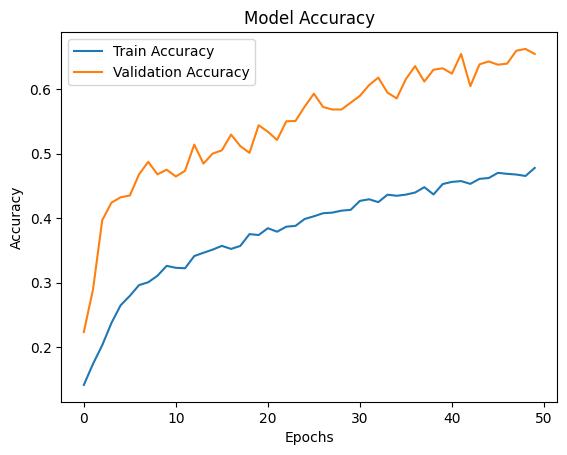

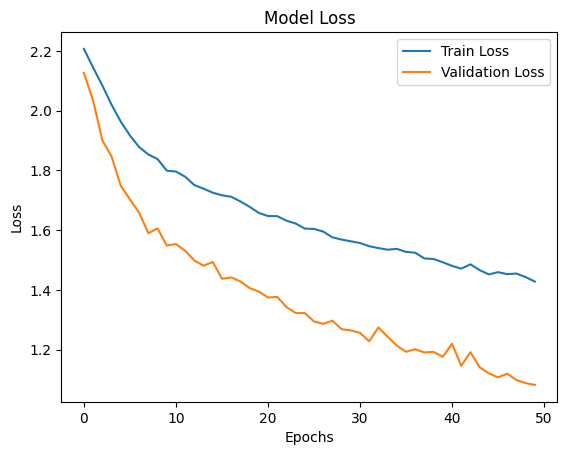

In [8]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')
plt.show()

# 8 Sonuçların Değerlendirilmesi

In [9]:
# Doğrulama seti için modelin yaptığı tahminler alınıyor.
val_predictions = model.predict(val_images)
# Tahminler ve gerçek etiketler en yüksek değere sahip indeksler alınarak karşılaştırılıyor.
val_predictions_classes = np.argmax(val_predictions, axis=1)
val_labels_classes = np.argmax(val_labels, axis=1)

# Tahminler ve gerçek sonuçlar arasındaki performans istatistikleri basılıyor.
print(classification_report(val_labels_classes, val_predictions_classes))

# Confusion matrix (karışıklık matrisi) oluşturuluyor.
conf_matrix = confusion_matrix(val_labels_classes, val_predictions_classes)


57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
              precision    recall  f1-score   support

           0       0.63      0.93      0.75       211
           1       0.72      0.43      0.54       204
           2       0.84      0.47      0.60       195
           3       0.74      0.86      0.80       191
           4       0.67      0.82      0.73       201
           5       0.55      0.40      0.46       179
           6       0.64      0.91      0.75       209
           7       0.45      0.20      0.28       207
           8       0.64      0.84      0.73       203

    accuracy                           0.65      1800
   macro avg       0.65      0.65      0.63      1800
weighted avg       0.65      0.65      0.63      1800

